<a href="https://colab.research.google.com/github/Mena-SA-Kamel/cell-features/blob/feature%2Fvae/VAE_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Variational Autoencoder to Extract Feature Embeddings from MNIST

In [1]:
# Python helpers
import os
import numpy as np

# Torch model imports
import torch
import torch.nn as nn

# Torch dataset imports
from torchvision.datasets import MNIST

# Torch data loader + transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Plotting functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

Creating Transforms

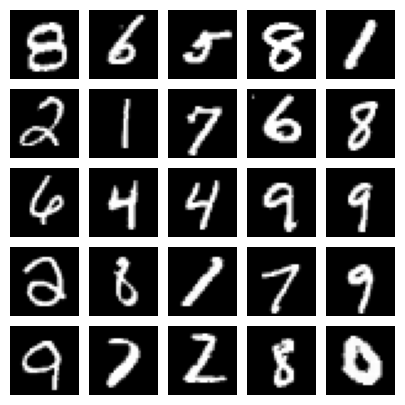

In [ ]:
# # Creating an iterator for the training data
# num_samples = 25
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# sample_images = [images[i,0] for i in range(num_samples)]

# fig = plt.figure(figsize=(5, 5))
# grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

# for ax, im in zip(grid, sample_images):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')

# plt.show()

Defining the VAE class

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
# download the MNIST datasets
path = '/content/datasets'
if not os.path.exists(path):
  os.makedirs(path, exist_ok=True)

train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(device)
# New VAE Class
class VariationalEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VariationalEncoder, self).__init__()
    # TODO: Change linear layers to Conv layers
    self.hidden_layer_1 = nn.Linear(input_dim, hidden_dim)
    self.mean_layer = nn.Linear(hidden_dim, latent_dim)
    self.logstd_layer = nn.Linear(hidden_dim, latent_dim)
    self.N = torch.distributions.Normal(0, 1) # Gaussian normalization
    self.N.loc = self.N.loc.cuda() # Moving the loc/ mean of the distribution to CUDA
    self.N.scale = self.N.scale.cuda() # Moving the scale/ std of the distribution to CUDA
    self.KL = 0

  def forward(self, x):
    x = torch.flatten(x, start_dim=1) # Flatten the image
    x = nn.functional.relu(self.hidden_layer_1(x))
    means = self.mean_layer(x)
    log_vars = torch.exp(self.logstd_layer(x)) # eNetwork predicting log(sigma **2) = log(var)
    # latent distribution using reparameterization trick to enable backpropagation
    z = means + (self.N.sample(means.shape) * torch.exp(0.5*log_vars)) # torch.exp(0.5*log_vars) -> sqrt(var) = sigma
    # KL divergence
    self.KL = (-0.5*(1 + log_vars - means**2 - torch.exp(log_vars))).sum() # torch.exp(log_vars)) -> var = sigma **2
    return z

class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()
    self.hidden_layer_1 = nn.Linear(latent_dim, hidden_dim)
    self.output_layer = nn.Linear(hidden_dim, output_dim)

  def forward(self, z):
    z = nn.functional.relu(self.hidden_layer_1(z))
    z = torch.sigmoid(self.output_layer(z)) # So it outputs a numpber between 0-1
    return z.reshape((-1, 1, 28, 28))


class VariationalAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VariationalAutoEncoder, self).__init__()
    self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

  def forward(self, x):
    z = self.encoder(x)
    x_hat = self.decoder(z)
    return x_hat

100%|██████████| 9912422/9912422 [00:00<00:00, 148606221.68it/s]

Extracting /content/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /content/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35565382.80it/s]

Extracting /content/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/datasets/MNIST/raw


100%|██████████| 1648877/1648877 [00:00<00:00, 61399818.86it/s]


Extracting /content/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18676988.99it/s]


Extracting /content/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/datasets/MNIST/raw

cuda


In [ ]:
def train(vae, data, epochs=20):
  optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
  for epoch in range(epochs):
    overall_loss = 0
    for batch_id, (x, _) in enumerate(data):
      x = x.to(device)
      optimizer.zero_grad()
      x_hat = vae(x)
      # reconstruction_loss = ((x - x_hat)**2).sum()
      reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
      loss = reconstruction_loss + vae.encoder.KL
      loss.backward()
      optimizer.step()
      overall_loss += loss.item()
    if batch_id > 0:
      print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_id*batch_size), "Reconstruction loss: ", reconstruction_loss.item(), "KL: ", vae.encoder.KL.item())
  return vae

vae = VariationalAutoEncoder(input_dim=784, hidden_dim=512, latent_dim=2).to(device)
vae = train(vae, train_loader, epochs=50)

	Epoch 1 	Average Loss:  192.66182931839523 Reconstruction loss:  16848.2578125 KL:  738.9357299804688
	Epoch 2 	Average Loss:  180.1927689215098 Reconstruction loss:  17599.51953125 KL:  693.1678466796875
	Epoch 3 	Average Loss:  178.9067781589107 Reconstruction loss:  16383.6279296875 KL:  803.4888305664062
	Epoch 4 	Average Loss:  178.25756403902338 Reconstruction loss:  16946.03515625 KL:  825.7801513671875
	Epoch 5 	Average Loss:  177.64113427978924 Reconstruction loss:  17094.95703125 KL:  725.8055419921875
	Epoch 6 	Average Loss:  177.37344604288398 Reconstruction loss:  16437.25390625 KL:  836.4501953125
	Epoch 7 	Average Loss:  177.09010238418196 Reconstruction loss:  17784.2265625 KL:  761.074951171875
	Epoch 8 	Average Loss:  176.96268645985498 Reconstruction loss:  16401.396484375 KL:  1014.7269287109375
	Epoch 9 	Average Loss:  176.85953384221096 Reconstruction loss:  16865.357421875 KL:  830.66650390625


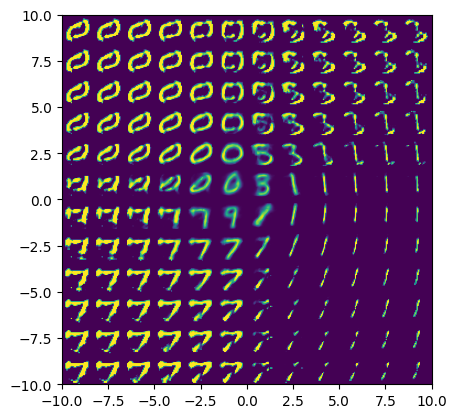

In [ ]:
def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed(vae)


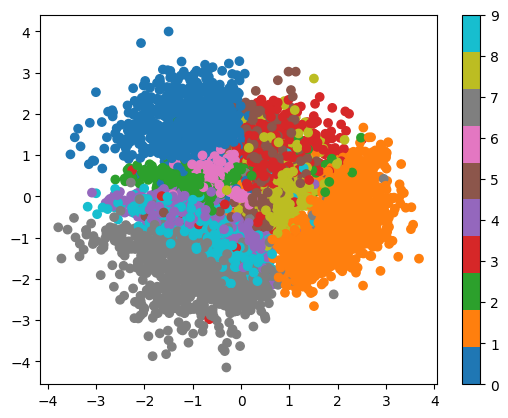

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
plot_latent(vae, train_loader)

In [ ]:
# class VAE(nn.Module):
#   def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
#     super(VAE, self).__init__()

#     #Encoder
#     self.encoder = nn.Sequential(
#         nn.Linear(input_dim, hidden_dim),
#         nn.LeakyReLU(0.2),
#         nn.Linear(hidden_dim, latent_dim),
#         nn.LeakyReLU(0.2)
#     )

#     # Latent mean and variance
#     self.mean_layer = nn.Linear(latent_dim, 1)
#     self.logvar_layer = nn.Linear(latent_dim, 1)

#     # Decoder
#     self.decoder = nn.Sequential(
#         nn.Linear(1, latent_dim),
#         nn.LeakyReLU(0.2),
#         nn.Linear(latent_dim, hidden_dim),
#         nn.LeakyReLU(0.2),
#         nn.Linear(hidden_dim, input_dim),
#         nn.Sigmoid()
#     )

#   def encode(self, x):
#     x = self.encoder(x)
#     mean, logvar = self.mean_layer(x), self.logvar_layer(x)
#     return mean, logvar

#   def reparametrization(self, mean, var):
#     epsilon = torch.randn_like(var).to(device)
#     z = mean + var*epsilon
#     return z

#   def decode(self, x):
#     return self.decoder(x)

#   def forward(self, x):
#     mean, logvar = self.encode(x)
#     z = self.reparametrization(mean, logvar)
#     x_hat = self.decode(z)
#     return x_hat, mean, logvar




In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

def train(model, optimizer, epochs, device, train_loader, x_dim=784):
    model.train()
    for epoch in range(epochs):
      overall_loss = 0
      for batch_idx, (x,_) in enumerate(train_loader):
        x = x.view(batch_size, x_dim).to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat,mean, log_var)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
      print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [ ]:
# %env CUDA_LAUNCH_BLOCKING=1
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print (device)
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, epochs=50, device=device, train_loader=train_loader)

cuda
	Epoch 1 	Average Loss:  191.0420168379591
	Epoch 2 	Average Loss:  178.5982775491705
	Epoch 3 	Average Loss:  175.5972118080916
	Epoch 4 	Average Loss:  173.08309893116132
	Epoch 5 	Average Loss:  171.49393062330446
	Epoch 6 	Average Loss:  170.20139247378444
	Epoch 7 	Average Loss:  169.44368516211915
	Epoch 8 	Average Loss:  168.234028703438
	Epoch 9 	Average Loss:  167.99747764829402
	Epoch 10 	Average Loss:  167.27224663175605
	Epoch 11 	Average Loss:  168.1018996667623
	Epoch 12 	Average Loss:  166.1470965117644
	Epoch 13 	Average Loss:  165.51791623734871
	Epoch 14 	Average Loss:  165.42674814469427
	Epoch 15 	Average Loss:  164.156658477019
	Epoch 16 	Average Loss:  163.99547626578152
	Epoch 17 	Average Loss:  163.62621553500625
	Epoch 18 	Average Loss:  163.98151256325647
	Epoch 19 	Average Loss:  162.85812123395763
	Epoch 20 	Average Loss:  162.58005606675187
	Epoch 21 	Average Loss:  162.5348662321317
	Epoch 22 	Average Loss:  162.4478403784954
	Epoch 23 	Average Loss: 

9510553.284179688

In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

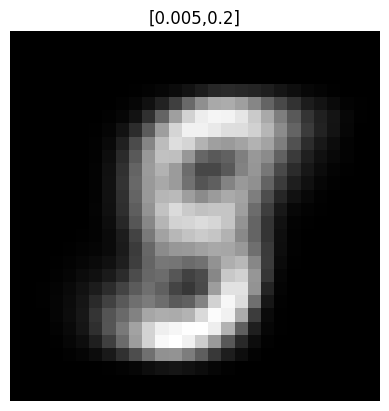

In [ ]:
generate_digit(0.005, 0.2)